In [3]:
import os,zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [5]:
!echo '{"username":"uytr84","key":"0c6e300ab156023e38d6873674c447e6"}' > ~/.kaggle/kaggle.json
! kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset
!chmod 600 /root/.kaggle/kaggle.json

 98% 204M/207M [00:01<00:00, 166MB/s]
100% 207M/207M [00:01<00:00, 133MB/s]


In [6]:
zip_path = '/content/covid-face-mask-detection-dataset.zip'
zip_ref = zipfile.ZipFile(zip_path)
zip_ref.extractall('.')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/covid-face-mask-detection-dataset.zip' mode='r'>>

In [7]:
base_dir ='/content/New Masks Dataset'
train_dir = os.path.join(base_dir, 'Train') 
test_dir = os.path.join(base_dir, 'Test') 
validation_dir = os.path.join(base_dir, 'Validation')
train_nomask_dir = os.path.join(train_dir, 'Non Mask')
train_mask_dir = os.path.join(train_dir, 'Mask')

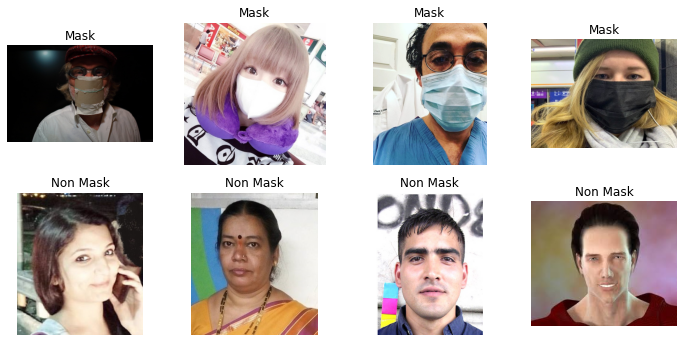

In [8]:

nrows = 4
ncols = 4
dir_list = os.listdir(train_dir)
mask_fnames = os.listdir(train_mask_dir)
nomask_fnames = os.listdir(train_nomask_dir)

pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols *3, nrows*3)

pic_index+=4

mask_pic = [os.path.join(train_mask_dir, fname) 
                for fname in mask_fnames[ pic_index-4:pic_index] 
              ]

nomask_pic = [os.path.join(train_nomask_dir, fname) 
                for fname in nomask_fnames[ pic_index-4:pic_index]
              ]



for i, img_path in enumerate(mask_pic + nomask_pic):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.title(os.path.basename(os.path.dirname(img_path)))
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

DATA AUGMENTATION

In [19]:
img_height = 192
img_width = 192
batch_sz = 32
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(     rescale=1./255,
                                        featurewise_center = False,
                                        samplewise_center = False,
                                        featurewise_std_normalization=False,  
                                        samplewise_std_normalization=False,
                                        rotation_range=40,
                                        width_shift_range=0.3,
                                        height_shift_range=0.3,
                                        zoom_range=0.2,
                                        fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)
# --------------------
# Flow training images in batches of 32 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory( train_dir,  
                                                target_size= (img_height,img_width), 
                                                batch_size=batch_sz,
                                                class_mode='binary')     
# --------------------
# Flow validation images in batches of 32 using test_datagen generator
# --------------------
valid_generator =  test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height,img_width),
                                                        batch_size= batch_sz,
                                                        class_mode='binary')

test_generator = validation_datagen.flow_from_directory(test_dir,
                                                    target_size=(img_height,img_width),
                                                    batch_size =  batch_sz,
                                                    class_mode = 'binary'
                                                    )


Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [11]:
pretrained_model = tf.keras.applications.MobileNet(
    input_shape=(192,192,3), include_top=False,
    weights='imagenet'
)
pretrained_model.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


In [23]:
mobinet = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

mobinet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [24]:
#SAVE BEST MODEL USING CALLBACK, EARLYSTOPPING
steps_per_epoch = tf.math.ceil(600/batch_sz).numpy()
callback = [tf.keras.callbacks.ModelCheckpoint(filepath='model_{epoch}.h5',
                                               save_weights_only=False, #save whole model
                                               save_best_only= True, # to keep only best file
                                               verbose=1,
                                               monitor='val_loss'),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=3,
                                                 verbose=1,
                                                 mode='min',
                                                 min_delta=0.001,
                                                 cooldown=2,
                                                 min_lr=1e-6),
            tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
            ]

history = mobinet.fit(train_generator,
                    epochs = 20,
                    steps_per_epoch=steps_per_epoch, 
                    callbacks= callback,
                    validation_data = valid_generator,
                    batch_size = 32)

Epoch 1/20
19/19 [==============================] - 16s 805ms/step - loss: 0.2857 - accuracy: 0.8750 - val_loss: 0.0611 - val_accuracy: 0.9837

Epoch 00001: val_loss improved from inf to 0.06114, saving model to model_1.h5
Epoch 2/20
19/19 [==============================] - 15s 779ms/step - loss: 0.1175 - accuracy: 0.9667 - val_loss: 0.0487 - val_accuracy: 0.9837

Epoch 00002: val_loss improved from 0.06114 to 0.04871, saving model to model_2.h5
Epoch 3/20
19/19 [==============================] - 14s 726ms/step - loss: 0.0759 - accuracy: 0.9767 - val_loss: 0.0460 - val_accuracy: 0.9837

Epoch 00003: val_loss improved from 0.04871 to 0.04597, saving model to model_3.h5
Epoch 4/20
19/19 [==============================] - 13s 700ms/step - loss: 0.0740 - accuracy: 0.9750 - val_loss: 0.0355 - val_accuracy: 0.9902

Epoch 00004: val_loss improved from 0.04597 to 0.03548, saving model to model_4.h5
Epoch 5/20
19/19 [==============================] - 13s 705ms/step - loss: 0.0434 - accuracy: 0.

Text(0.5, 0, 'epoch')

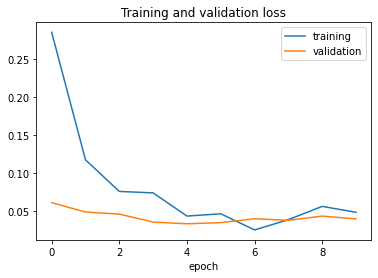

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Training and validation loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

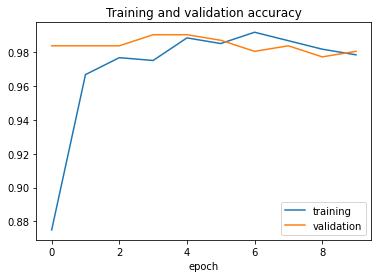

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')

In [27]:
# Recreate the exact same model, including its weights and the optimizer
restored_model = tf.keras.models.load_model('model_7.h5')

# Show the model architecture
restored_model.summary()

# We need to define its optimizer and loss function again since the h5 file
# does not contain those information :(
restored_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=["accuracy"])

# Re-evaluate the model
loss, acc = restored_model.evaluate(valid_generator)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_192 (Function (None, 6, 6, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 3,294,529
Trainable params: 65,665
Non-trainable params: 3,228,864
_________________________________________________________________
10/10 [==============================] - 5s 454ms/step - loss: 0.0380 - accuracy: 0.9837
Restored model, 

In [48]:
def prediction(path):
  img=image.load_img(path, target_size=(192,192))

  x=image.img_to_array(img).astype('float32')/255
  x=np.expand_dims(x, axis=0)
  # print(x)

  classes = restored_model.predict(x)
  # img = mpimg.imread(path)
  # plt.imshow(img)
  # print("Predicted Class:",classes)

  if classes[0][0]>0.5:
    re = 'No Mask'
  else:
    re= 'Mask'
  return re

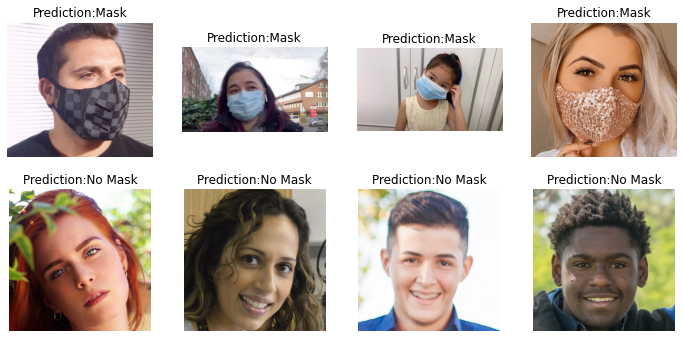

In [49]:
nrows = 4
ncols = 4
dir_list = os.listdir(test_dir)
mask_fnames = os.listdir('/content/New Masks Dataset/Test/Mask')
nomask_fnames = os.listdir('/content/New Masks Dataset/Test/Non Mask')

pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols *3, nrows*3)

pic_index+=4

mask_pic = [os.path.join('/content/New Masks Dataset/Test/Mask', fname) 
                for fname in mask_fnames[ pic_index-4:pic_index] 
              ]

nomask_pic = [os.path.join('/content/New Masks Dataset/Test/Non Mask', fname) 
                for fname in nomask_fnames[ pic_index-4:pic_index]
              ]



for i, img_path in enumerate(mask_pic + nomask_pic):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    pred = prediction(img_path)
    plt.title(f'Prediction:{pred}')
  
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [50]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()


Saving 7459826_102920-wtvd-psychology-of-masks-img.jpg to 7459826_102920-wtvd-psychology-of-masks-img.jpg


Predicted Class: [[0.00220539]]
Mask(s) found in 7459826_102920-wtvd-psychology-of-masks-img.jpg


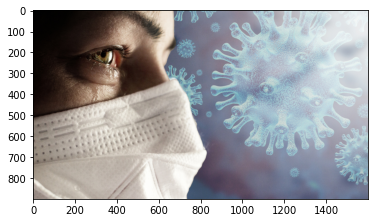

In [51]:
for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(192,192))
  
  x=image.img_to_array(img).astype('float32')/255
  x=np.expand_dims(x, axis=0)
  # print(x)
  
  classes = restored_model.predict(x)
  img = mpimg.imread(path)
  plt.imshow(img)
  print("Predicted Class:",classes)
  
  if classes[0][0]<0.5:
    print(f'Mask(s) found in {fn}')
  else:
    print(f'No mask(s) found in {fn}')